In [99]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from collections import OrderedDict

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.qam_crazy import crazy_channel_propagate
from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

In [144]:
Mod = 'QAM'
channel_type = 'rayleigh' # 'awgn' or 'crazy' or 'rayleigh'
M            = 4      # PSK modulation
total_num_symbols  = 8    # Number of transmitted symbols to be used for training and test
train_fraction = 0.8 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 30      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [145]:
symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)

In [146]:
channel_output

(array([ 0.55685781-0.55777498j, -0.51542225-0.52853451j,
         0.88765535+0.89218394j, -0.48485259-0.50702412j,
        -0.7684518 -0.77153315j,  0.32151142-0.31625959j,
        -0.63668892+0.58209419j,  1.02406751+1.00790891j]),
 array([0.78785612, 0.75185373, 1.28136618, 0.68861807, 1.10026721,
        0.42945203, 0.86782426, 1.40161285]))

In [147]:
symbs_ = symbs[:]

In [148]:
indices = list(OrderedDict.fromkeys(indices))

In [149]:
symbs = np.array(list(OrderedDict.fromkeys(symbs))).reshape(1,-1)

In [150]:
alph = channel_output[1]

In [151]:
channel_output = channel_output[0].reshape(-1,1)

In [152]:
d = dict(zip(symbs[0], indices))

In [153]:
d

{(0.7071067811865475-0.7071067811865475j): 2,
 (-0.7071067811865475-0.7071067811865475j): 0,
 (0.7071067811865475+0.7071067811865475j): 3,
 (-0.7071067811865475+0.7071067811865475j): 1}

In [154]:
input = []
for i in range(total_num_symbols):
    input.append(d[symbs_[i]])

In [164]:
symb_min = [[],[]]
for a, desv in zip(channel_output, alph):
    print(np.abs(a - symbs), "=",np.argmin(np.abs(np.array(a) - symbs)),"--", np.abs(np.array(a) - np.array(desv) * symbs),np.argmin(np.abs(a - desv * symbs)), "\n")
    symb_min[0].append(symbs[0, np.argmin(np.abs(a - symbs))])
    symb_min[1].append(symbs[0, np.argmin(np.abs(a - desv * symbs))])

[[0.21183659 1.27275546 1.27377416 1.78816452]] = 0 -- [[7.18080153e-04 1.11395642e+00 1.11487341e+00 1.57602066e+00]] 0 

[[1.23550204 0.26197522 1.73821363 1.25042087]] = 1 -- [[1.04706773 0.01651342 1.49007148 1.06029942]] 1 

[[1.60944979 2.25853871 0.25855627 1.60546561]] = 2 -- [[1.79834087 2.53990463 0.02305322 1.79377176]] 2 

[[1.20863568 0.29904848 1.70143498 1.23430579]] = 1 -- [[0.97198689 0.02020434 1.39006923 0.99395279]] 1 

[[1.47696441 0.08896049 2.08893494 1.47991191]] = 1 -- [[1.54647175 0.01154095 2.18920209 1.54956901]] 1 

[[0.54904035 1.10037127 1.09360071 1.45097696]] = 0 -- [[0.02183824 0.62530664 0.62018476 0.88043207]] 0 

[[1.86220998 1.2911227  1.3495981  0.14348109]] = 3 -- [[1.73006481 1.19596065 1.25073133 0.03907001]] 3 

[[1.74405932 2.43685109 0.43697371 1.75711307]] = 2 -- [[1.99927085 2.83846015 0.03701887 2.01522765]] 2 



In [ ]:
np.abs(channel_output[2] - )

In [129]:
symb_min[0]

[(-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475+0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j)

In [130]:
symb_min[1]

[(-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475+0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475+0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475+0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (0.7071067811865475-0.7071067811865475j),
 (-0.7071067811865475-0.7071067811865475j)

In [75]:
output = [[],[]]
for i in range(total_num_symbols):
    output[0].append(d[symb_min[0][i]])
    output[1].append(d[symb_min[1][i]])

IndexError: invalid index to scalar variable.

In [60]:
output_ = []
for i in range(total_num_symbols):
    output_.append(d[symb_min_[i]])

In [54]:
symb_min_ = []
for a in channel_output:
    symb_min_.append(symbs[0, np.argmin(np.abs(a - symbs))])

In [ ]:
output

In [20]:
np.array(input) != np.array(output)

array([False, False, False, ..., False, False, False])

In [93]:
def error_symb(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, desv_test):
    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)
    symbs_ = symbs[:]
    indices = list(OrderedDict.fromkeys(indices))
    symbs = np.array(list(OrderedDict.fromkeys(symbs))).reshape(1,-1)
    alph = channel_output[1]

    channel_output = channel_output[0].reshape(-1,1)
    
    d = dict(zip(symbs[0], indices))
    
    input = []
    for i in range(total_num_symbols):
        input.append(d[symbs_[i]])

    if desv_test:
        symb_min = [[],[]]
        for a, desv in zip(channel_output, alph):
            symb_min[0].append(symbs[0, np.argmin(np.abs(a - symbs))])    
            symb_min[1].append(symbs[0, np.argmin(np.abs(a - desv * symbs))])
        
        output = [[],[]]
        for i in range(total_num_symbols):
            output[0].append(d[symb_min[0][i]])
            output[1].append(d[symb_min[1][i]])

        return [np.sum(np.array(input) != np.array(out)) for out in output] / np.array(total_num_symbols)
    else:
        symb_min = []
        for a, desv in zip(channel_output, alph):
            symb_min.append(symbs[0, np.argmin(np.abs(a - desv * symbs))])
        
        output = []
        for i in range(total_num_symbols):
            output.append(d[symb_min[i]])

        return np.sum(np.array(input) != np.array(output)) / total_num_symbols

In [19]:
symbs, indices, channel_output = Model(Mod, 30000, M, channel_type, Es, code_rate, 50) 

In [20]:
np.average(channel_output)

(0.0016095592486235447-0.001096672132294552j)

In [5]:
np.var(channel_output)

9.872710145606834e-06

In [14]:
symbs, indices, channel_output = Model(Mod, 30000, M, channel_type, Es, code_rate, 18) 

In [9]:
np.average(channel_output)

(-0.008453822278183467+0.0036049965325919532j)

In [10]:
np.var(channel_output)

1.0022622035555555

OBS: Realizar simulação com conhecimento do desvanecimento, e sem o conhecimento.

# Geração do gráfico

### 12dB - 18dB

In [157]:
Mod = "QAM"
channel_type = "awgn"
M = 64
Es = 1
code_rate = 1
init_scale = 8
interval = 7

In [158]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type, epb=False) for i in range(interval)]

In [159]:
Teo_SNRs

[0.7605338089479445,
 0.7203947912432307,
 0.673826332202452,
 0.6204536473205775,
 0.5602522056912801,
 0.49373440300145405,
 0.42214666526462574]

In [160]:
error_rate = np.array([error_symb(Mod, int(100 / Teo_SNRs[i]), M, channel_type, Es, code_rate, init_scale + i, True) for i in range(interval)]).T

In [161]:
error_rate

array([[0.77099237, 0.7173913 , 0.64189189, 0.54658385, 0.52247191,
        0.45544554, 0.40677966],
       [0.77099237, 0.7173913 , 0.64189189, 0.54658385, 0.52247191,
        0.45544554, 0.40677966]])

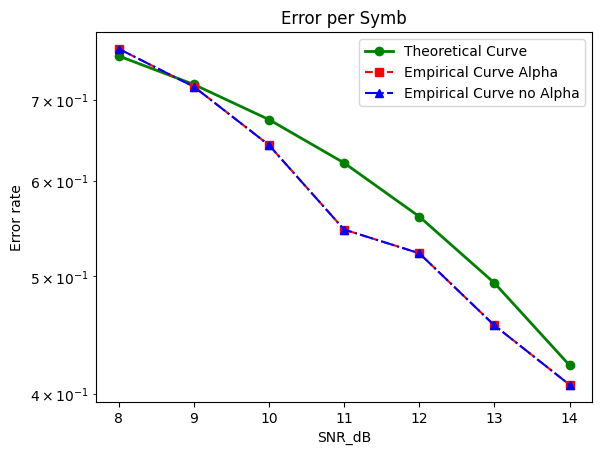

In [162]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval)
y2 = error_rate[1]
y3 = error_rate[0]

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve Alpha')
ax.plot(x, y3, 'b^-.', label='Empirical Curve no Alpha')

ax.set_title('Error per Symb')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Error rate')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()